In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import random

%matplotlib inline


- objects count not correlated with area (objects/background) [TODO]
- randomized shapes? [TODO]
- randomized placement
- no overlaps
- what else?
- random color for objects


In [4]:


class GenerateImagesWithObjects:
    def __init__(self, 
                 obj_count_range=range(1, 50),
                 obj_size_range=(5, 15),
                 obj_distance_range=(5,20),
                 distribiuton='uniform',
                 image_shape=(150, 150, 3),
                 edge_dist=20,  
                 background='noise',
                 area_filling=0.1,
                 black_and_white=False
                ):
        
        self.obj_count_range = obj_count_range
        self.obj_size_range = obj_size_range
        self.obj_distance_range = obj_distance_range
        self.distribiuton = distribiuton
        self.image_shape = image_shape
        self.edge_dist = edge_dist
        self.background = background
        self.black_and_white = black_and_white
        self.color_shape = 3
        self.area_filling = area_filling
        if self.black_and_white:
            self.image_shape=self.image_shape[:2]
            self.color_shape = 1
            
        
    @staticmethod    
    def _circles_are_overlapping(circle1, circle2):
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        if circle1 == circle2:
            return True
        return abs(r0-r1)^2 <= ((x0-x1)^2 + (y0-y1)^2 <= (r0 + r1)^2)
    
    def _random_color(self):
        r = np.random.randint(20, 220, size=(self.color_shape), dtype=int)
        return tuple([int(i) for i in r])



    def _circles_are_distant(self, circle1, circle2):  
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        dst = distance.euclidean((x0,y0),(x1,y1)) - (r0 + r1)
        return dst>np.random.randint(*self.obj_distance_range)
    
    
    def _can_place_circle(self, circles_drawn, new_circle):
        x,y,r = new_circle
        canvas_shape = self.image_shape[1]
        if not(
        (0 <= x - r <= canvas_shape) and \
        (0 <= y - r <= canvas_shape) and \
        (0 <= x + r <= canvas_shape) and \
        (0 <= y + r <= canvas_shape)
        ):
            return False # circle is not overlapping with cnavas edge   
        return all([self._circles_are_distant(new_circle, c_on_canvas) for c_on_canvas in circles_drawn])
    
    
    
    def _get_random_circle(self):
        if self.distribiuton == 'uniform':
            x = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            y = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            r = np.random.randint(*self.obj_size_range) 
            
        return x,y,r
    
    def _generate_N_circle_radiuses_with_same_sum_of_areas(self, n_circles):
        rows, columns = self.image_shape[:2]
        canvas_size = rows  * columns
        n_circles = np.random.rand(n_circles)
        factor = np.sqrt((canvas_size * self.area_filling / np.pi) / np.sum(n_circles**2))
        good_circles_radiuses = n_circles * factor  
        return good_circles_radiuses

    
    def _get_canvas(self):    
        if self.background == 'noise':
            canvas = np.random.randint(1, 255, size=self.image_shape, dtype='uint8')
        elif self.background == 'white':
            canvas = np.zeros(self.image_shape[0], dtype='uint8')
        return canvas
    
                    
    def generate_image(self, nr_objects):
        canvas = self._get_canvas()

        circles_drawn = []
        radiuses = self._generate_N_circle_radiuses_with_same_sum_of_areas(nr_objects)
        x = y = r = None
        emergency_counter = 0
        for r in radiuses:
            random_color = self._random_color()
            x,y,_ = self._get_random_circle()
            while not self._can_place_circle(circles_drawn, (x, y, r)):
                x,y,_ = self._get_random_circle()    
                emergency_counter+=1
                if emergency_counter>100000:
                    print('ERROR EMERGENCY EXIT')
                    break
            x, y, r = int(x), int(y), int(r)
            cv2.circle(canvas, (x,y),r, random_color, -1)
            circles_drawn.append((x,y,r))
            
                
        return canvas/255.0
    
    
    def _generate_batch_of_images(self, batch_size=32):
        batch = []
        for _ in range(batch_size):
            target_y = random.randint(nr_of_objecs_range)
            batch.append(self.generate_image)
        
        return np.concatenate(batch)
    
    
    def image_generator(self, nr_of_objecs_range=range(1,10), batch_size=32):
        while True:
            batch = []
            ys = []
            for _ in range(batch_size):
                target_y = random.randint(nr_of_objecs_range[0], nr_of_objecs_range[-1])
                batch.append(np.expand_dims(self.generate_image(target_y), 0))
                ys.append(target_y)
            yield (np.concatenate(batch), np.array(ys).reshape(-1, 1))
        
    
    

                
                

In [5]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.layers import Layer
from keras.optimizers import Adam

class Round(Layer):

    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def create_model(img_rows=150, img_cols=150):
    model = Sequential()
    model.add(Convolution2D(64, 3, 3, input_shape=(img_rows, img_cols, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Round())

    return model

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5105)


In [6]:
model = create_model()
adam = Adam(lr=0.001)
model.compile(
    loss='mean_absolute_percentage_error',
    optimizer=adam,
    metrics=['mean_absolute_percentage_error']
)


In [7]:
go = GenerateImagesWithObjects()
ig = go.image_generator(batch_size=32)
history = model.fit_generator(ig, 750, nb_epoch=1000)

Epoch 1/1000
768/750 [==============================] - 3s - loss: 64.6139 - mean_absolute_percentage_error: 64.6139     
Epoch 2/1000
 32/750 [>.............................] - ETA: 3s - loss: 60.3142 - mean_absolute_percentage_error: 60.3142

/home/i008/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


768/750 [==============================] - 3s - loss: 61.3856 - mean_absolute_percentage_error: 61.3856     
Epoch 3/1000
768/750 [==============================] - 3s - loss: 60.7701 - mean_absolute_percentage_error: 60.7701     
Epoch 4/1000
768/750 [==============================] - 3s - loss: 60.7737 - mean_absolute_percentage_error: 60.7737     
Epoch 5/1000
320/750 [===========>..................] - ETA: 1s - loss: 63.3140 - mean_absolute_percentage_error: 63.3140

KeyboardInterrupt: 

NameError: name 'history' is not defined

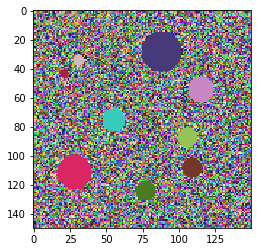

In [7]:
go = GenerateImagesWithObjects()
g = go.image_generator()
# x, y = g.next()


plt.imshow(go.generate_image(10))

In [15]:
x, y = g.next()
p = model.predict_on_batch(x)
print(p)
print(y)



[[  0.98046231]
 [  6.64620972]
 [  2.01062489]
 [  0.98440552]
 [  5.52805567]
 [  2.1523788 ]
 [  0.98549473]
 [  2.06814599]
 [  2.8882668 ]
 [  0.9832443 ]
 [  7.89057112]
 [  8.11708736]
 [  8.0154953 ]
 [  8.80125999]
 [  3.8384006 ]
 [  4.3815856 ]
 [  0.9851054 ]
 [  7.55758333]
 [  0.98779166]
 [  7.29399347]
 [  2.01344252]
 [  5.38123512]
 [  5.47718906]
 [  4.21924543]
 [  5.40777493]
 [  5.75772858]
 [ 10.13844776]
 [  8.07097626]
 [  7.77451897]
 [  9.06738281]
 [  4.26233339]
 [  0.9821521 ]]
[[1]
 [6]
 [2]
 [1]
 [7]
 [2]
 [1]
 [2]
 [3]
 [1]
 [9]
 [8]
 [9]
 [8]
 [4]
 [4]
 [1]
 [9]
 [1]
 [6]
 [2]
 [5]
 [6]
 [6]
 [8]
 [5]
 [9]
 [7]
 [7]
 [8]
 [4]
 [1]]


In [21]:
im = cv2.imread('circles.jpg')
from imutils import resize


# im = resize(im, width=400, height=400)
# model.predict(np.expand_dims(im, 0))

In [21]:
im.shape

(520, 502, 3)

In [22]:
resize(im, height=400).shape

(400, 400, 3)

In [23]:
def load_img(path, grayscale=False, target_size=None):
    """
    Load an image into PIL format.
    # Arguments
    path: path to image file
    grayscale: boolean
    target_size: None (default to original size)
    or (img_height, img_width)
    """

    img = Image.open(path)
    if grayscale:
        img = img.convert('L')
    else:  # Ensure 3 channel even when loaded image is grayscale
        img = img.convert('RGB')
    if target_size:
        img = img.resize((target_size[1], target_size[0]))
    return img


from PIL import Image


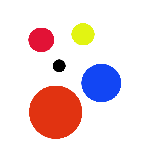

In [26]:
im = load_img('circles.jpg')
im = im.resize((150, 150))
im

In [29]:
im2 = np.asarray(im)
im2 = im2/255.0
im2[:50, :50]
# model.predict(np.expand_dims(im2,0))


array([[[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       ..., 
       [[ 1.        ,  1.        ,  1.        ],
        

(150, 150, 3)

In [142]:
go = GenerateImagesWithObjects(obj_size_range=(5,15))

In [143]:
x = np.expand_dims(go.generate_image(1), 0)

In [144]:
x.shape

(1, 400, 400, 3)

In [145]:
model.predict(x)

array([[ 2.04513907]], dtype=float32)

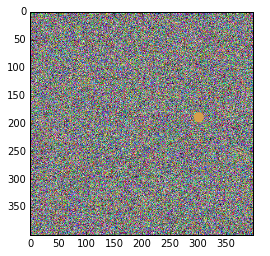

In [73]:
plt.imshow(x[0])

ERROR EMERGENCY EXIT
ERROR EMERGENCY EXIT


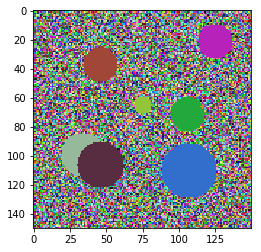

In [54]:

plt.imshow(go.generate_image(10))

In [8]:

from quiver_engine import server
from quiver_engine import server

In [9]:
server.launch(model)

Starting webserver from: /home/i008/anaconda2/lib/python2.7/site-packages/quiver_engine


::ffff:127.0.0.1 - - [2017-03-03 20:39:49] "GET /model HTTP/1.1" 200 7630 0.002379
::ffff:127.0.0.1 - - [2017-03-03 20:39:49] "GET /inputs HTTP/1.1" 200 189 0.000852
[2017-03-03 20:39:57,798] ERROR in app: Exception on /predict/NucleiDAPIconfocal.png [GET]
Traceback (most recent call last):
  File "/home/i008/anaconda2/lib/python2.7/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/i008/anaconda2/lib/python2.7/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/i008/anaconda2/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/home/i008/anaconda2/lib/python2.7/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/i008/anaconda2/lib/python2.7/site-packages/flask/app.py", line 1612, in full_disp

KeyboardInterrupt: 

In [16]:
w = model.layers[6]

Elemwise{add,no_inplace}.0